In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
import torch.optim as optim
from torchvision.ops import box_iou

from datetime import datetime
import matplotlib.pyplot as plt

import pickle

### Important
Be sure to corerct paths to match your own computer if you are running this locally

In [2]:
# importingg for google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# setting up the seed
seed = 42
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# Part 1 Object Localization

In [4]:
# For google colab
paths_loc = ['/content/drive/MyDrive/inf265-p2/data/localization_train.pt',
          '/content/drive/MyDrive/inf265-p2/data/localization_val.pt',
          '/content/drive/MyDrive/inf265-p2/data/localization_test.pt']

# For main computer
#paths_loc = [
#        'data/localization_train.pt',
#        'data/localization_val.pt',
#        'data/localization_test.pt'
#         ]

# normalization function, reads the training data and calculates the mean and std

def norm_data(training_data_path):
    train_temp = torch.load(training_data_path)
    imgs = torch.stack([img for img,_ in train_temp])

    mean = imgs.mean(dim=(0,2,3))
    std = imgs.std(dim=(0,2,3))
    normalizer = transforms.Normalize(mean, std)
    preprocessor = transforms.Compose([normalizer])

    return preprocessor, mean, std

# is used to denormalize the image for plotting
def denorm_img(img, mean, std):
    mean = mean.to(device=device)
    std = std.to(device=device)
    img = img * std + mean
    return img


# custom function to load the data

def load_custom_dataset(paths = None, preprocessor=None):

    data_train = torch.load(paths[0])
    data_val = torch.load(paths[1])
    data_test = torch.load(paths[2])

    if preprocessor:
        data_train = [(preprocessor(img), label) for (img, label) in data_train]
        data_val = [(preprocessor(img), label) for (img, label) in data_val]
        data_test = [(preprocessor(img), label) for (img, label) in data_test]

    return data_train, data_val, data_test

#for plotting some images from each class

def print_classes(loader):
    class_images = {}

    for batch, labels in loader:
        for img, label in zip(batch, labels):
            label = label[-1]
            if label not in class_images:
                class_images[int(label)] = img
            if len(class_images) == 10:
                break
        if len(class_images) == 10:
            break
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,3))

    for i, ax in enumerate(axes.flat):
        img = class_images[i]
        ax.imshow(img.permute(1,2,0), cmap='gray')
        ax.set_title(i)
        ax.axis('off')

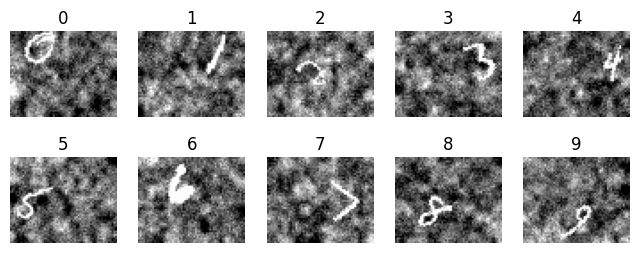

In [5]:
#this reads the data and preprocesses it with the normalization function
preprocessor_loc, mean_loc, std_loc = norm_data(paths_loc[0])
data_train, data_val, data_test = load_custom_dataset(paths=paths_loc, preprocessor=preprocessor_loc)

temp_loader = torch.utils.data.DataLoader(data_train, batch_size=512, shuffle=False)
print_classes(loader=temp_loader)

In [6]:
def fix_box_dim(boxes, width, height):
    # Fixing the boxes size #
    # boxes: [x_center, y_center, width, height]

    boxes_2d = boxes.unsqueeze(0)       
    boxes_scaled = boxes_2d.clone()
    boxes_scaled[:, 0] *= width
    boxes_scaled[:, 1] *= height
    boxes_scaled[:, 2] *= width
    boxes_scaled[:, 3] *= height

    boxes_reshaped = box_convert(boxes_scaled, 'cxcywh', 'xyxy')
    # boxes: [x_min, y_min, x_max, y_max]
    return boxes_reshaped

def draw_bb(img=None, true_box=None, pred_box=None, true_class=None, pred_class=None, ax=None, denorm=None, width=60, height=48):
    # img: tensor of shape (C, H, W)
   

    # if we need to denormalize the image #
    if denorm:
        img = img.clone()
        img = denorm_img(img, denorm[0], denorm[1])

    # Fixing the image size #
    img_uint8 = (img.clone() * 255).type(torch.uint8)

    # Fixing the boxes size #
    true_boxes, pred_boxes = [], []
    #is made to handle multiple boxes or just one box
    if true_box is not None:
        if isinstance(true_box, list):
            true_boxes = [fix_box_dim(box.clone(), width, height) for box in true_box]
        else:
            true_boxes = [fix_box_dim(true_box.clone(), width, height)]
    # is made to handle multiple boxes or just one box
    if pred_box is not None:
        if isinstance(pred_box, list):
            pred_boxes = [fix_box_dim(box.clone(), width, height) for box in pred_box]
        else:
            pred_boxes = [fix_box_dim(pred_box.clone(), width, height)]

    # colors for the boxes corresponding to the true and predicted boxes
    colors = ['red' for _ in true_boxes] + ['blue' for _ in pred_boxes] #red for true, blue for pred
    all_boxes = torch.cat(true_boxes + pred_boxes, dim=0)

    # Drawing the boxes #
    drawn_boxes = draw_bounding_boxes(img_uint8, all_boxes, colors=colors)
    transform = transforms.Compose([transforms.ToPILImage()])
    ax.imshow(transform(drawn_boxes))

    # Adding the labels #
    center_boxes = [box_convert(box, 'xyxy', 'cxcywh') for box in all_boxes]

    title = []

    # Adding the classes #
    if (true_class != None) and true_class.numel() == 1:
        title.append(f"T {int(true_class.clone())}")

    else:
        for nmbr in true_class:
            title.append(f"T {int(nmbr.clone())}")

    if (pred_class != None) and pred_class.numel() == 1:
        title.append(f"P {int(pred_class.clone())}")

    else:
        for nmbr in pred_class:
            title.append(f"P {int(nmbr.clone())}")

    # Adding the title #
    if title:
        ax.set_title(' & '.join(title))
    else:
        ax.set_title('')

    for i, box in enumerate(center_boxes):
        #adding thext for the center of the predictiona and true boxes
        if len(true_boxes) == 1:
            label = true_class if i < len(true_boxes) else pred_class
            color = 'red' if i < len(true_boxes) else 'blue'
            x = box[0].item()
            y = box[1].item()

            ax.text(x, y, int(label.item()), fontsize=12, color=color)

    ax.axis('off')


In [7]:
class SkreNet(nn.Module):
    def __init__(self):
        super(SkreNet, self).__init__()

        # First layer
        self.cv1 = nn.Conv2d(1, 10, 3, stride=1, padding=1)
        self.act1 = nn.ReLU()

        # Second layer
        self.cv2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.act2 = nn.ReLU()

        # Third layer
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fourth layer
        self.cv3 = nn.Conv2d(20, 35, 3, stride=1, padding=1)
        self.act3 = nn.ReLU()

        # Fifth layer
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Sixth layer
        self.cv4 = nn.Conv2d(35, 40, 3, stride=1, padding=1)
        self.act4 = nn.ReLU()

        self.flat = nn.Flatten()


        # Output layer
        # We add different act functions for different parts of the output

        self.fc1 = nn.Linear(12*15*40, 5000)
        self.act5 = nn.ReLU()

        self.fc2 = nn.Linear(5000, 500)
        self.act6 = nn.ReLU()

        self.fc3 = nn.Linear(500, 15)

    def forward(self, x):
        out = self.act1(self.cv1(x))       # The output of the 1. layer and activation functions is the input of the next
        out = self.act2(self.cv2(out))
        out = self.mp1(out)
        out = self.act3(self.cv3(out))
        out = self.mp2(out)
        out = self.act4(self.cv4(out))

        out = self.flat(out)
        out = self.act5(self.fc1(out))                 # No activation function for the last layer, as this will be handeled by
        out = self.act6(self.fc2(out))                 # the custom loss function
        out = self.fc3(out)

        return out

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        # First layer
        self.cv1 = nn.Conv2d(1, 3, 3, stride=1, padding=1)
        self.act1 = nn.ReLU()

        # Second layer
        self.cv2 = nn.Conv2d(3, 10, 3, stride=1, padding=1)
        self.act2 = nn.ReLU()

        # Third layer
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fourth layer
        self.cv3 = nn.Conv2d(10, 15, 3, stride=1, padding=1)
        self.act3 = nn.ReLU()

        # Fifth layer
        self.cv4 = nn.Conv2d(15, 20, 3, stride=1, padding=1)
        self.act4 = nn.ReLU()

        self.flat = nn.Flatten()

        # Output layer
        # We add different act functions for different parts of the output

        self.fc1 = nn.Linear(24*30*20, 15)

    def forward(self, x):
        out = self.act1(self.cv1(x))       # The output of the 1. layer and activation functions is the input of the next
        out = self.act2(self.cv2(out))
        out = self.mp1(out)
        out = self.act3(self.cv3(out))
        out = self.act4(self.cv4(out))

        out = self.flat(out)
        out = self.fc1(out)                 # No activation function for the last layer, as this will be handeled by
                                            # the custom loss function
        return out

In [9]:
class FloNet(nn.Module):
    def __init__(self):
        super(FloNet, self).__init__()

        # First layer
        self.cv1 = nn.Conv2d(1, 10, 3, stride=1, padding=1)
        self.act1 = nn.ReLU()

        # Second layer
        self.cv2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.act2 = nn.ReLU()

        # Third layer
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fourth layer
        self.cv3 = nn.Conv2d(20, 35, (3,5), stride=1, padding=1)
        self.act3 = nn.ReLU()

        # Fifth layer
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Sixth layer
        self.cv4 = nn.Conv2d(35, 40, 3, stride=1, padding=1)
        self.act4 = nn.ReLU()

        # Seventh layer
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Eight layer
        self.cv5 = nn.Conv2d(40, 50, 3, stride=1, padding=1)
        self.act5 = nn.ReLU()

        self.flat = nn.Flatten()


        # Output layer
        # We add different act functions for different parts of the output

        self.fc1 = nn.Linear(6*7*50, 500)
        self.act6 = nn.ReLU()

        self.fc2 = nn.Linear(500, 15)

    def forward(self, x):
        out = self.act1(self.cv1(x))       # The output of the 1. layer and activation functions is the input of the next
        out = self.act2(self.cv2(out))
        out = self.mp1(out)
        out = self.act3(self.cv3(out))
        out = self.mp2(out)
        out = self.act4(self.cv4(out))
        out = self.mp3(out)
        out = self.act5(self.cv5(out))

        out = self.flat(out)
        out = self.act6(self.fc1(out))                 # No activation function for the last layer, as this will be handeled by
                                                       # the custom loss function
        out = self.fc2(out)

        return out

In [10]:
def loss_(pred, labels, task='det'):
    # works with both localization and detection
    if task == 'loc':
        reduction = 'mean'
    # changes the shape of the prediction and labels to work with the loss function
    # if the task is detection
    if task == 'det':
        reduction = 'mean'
        pred = torch.permute(pred, (0,2,3,1))
        pred = pred.flatten(start_dim=0, end_dim=2)
        labels = labels.flatten(start_dim=0, end_dim=2)


    detection_pred = pred[:, 0]
    detection_true = labels[:, 0]

    L_a = nn.BCEWithLogitsLoss(reduction=reduction)(detection_pred, detection_true)

    mask = detection_true.bool()

    box_coordinates_pred = pred[:, 1:5]
    box_coordinates_true = labels[:, 1:5]

    # calculating the loss for the box coordinates
    L_b = nn.MSELoss(reduction=reduction)(box_coordinates_pred[mask], box_coordinates_true[mask])

    # calculating the loss for the classes
    if task == 'loc':
        class_probabilities_pred = pred[:, 5:]
        class_true = labels[:, 5].long()

        L_c = nn.CrossEntropyLoss(reduction=reduction)(class_probabilities_pred[mask], class_true[mask])
    # calculating the loss for binary classification
    if task == 'det':
        class_probabilities_pred = pred[:, 5]
        class_true = labels[:, 5]

        L_c = nn.BCEWithLogitsLoss(reduction=reduction)(class_probabilities_pred[mask], class_true[mask])


    tot_loss = L_a + L_b + L_c

    return tot_loss

In [11]:
def performance(model, loader, task='det'):
    model.eval()
    correct = 0
    total = 0
    box_accuracies = []

    # We do not want gradients here, as we will not want to update the parameters.
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            # Feeds the batches to the model
            outputs = model(imgs)

            #here we change the shape of the prediction and labels to work with the performance function
            if task == 'det':
                outputs = torch.permute(outputs, (0,2,3,1))
                outputs = outputs.flatten(start_dim=0, end_dim=2)
                labels = labels.flatten(start_dim=0, end_dim=2)

            #we use the sigmoid function since the output is "raw" logits
            pred_detection = torch.sigmoid(outputs[:,0])
            pred_box = outputs[:,1:5]
            _, pred_class = torch.max(outputs[:,5:], dim=1)

            true_detection = labels[:,0]

            true_box = labels[:,1:5]
            true_class = labels[:,5]

            # here we calculate the accuracy for the detection task
            # a correct counts if true deteciton is 1 and the predicted detection is above 0.5
            # or if the true detection is 0 and the predicted detection is below 0.5
            correct = correct + ((pred_detection >= 0.5) & (true_detection == 1) & (pred_class == true_class) |
                        (pred_detection < 0.5) & (true_detection == 0)).sum().item()

            total = total + labels.shape[0]
            mask = (true_detection == 1) & torch.gt(pred_detection, 0.5)

            # here we calculate the box accuracy by calculating the iou between the predicted and true boxes
            # we also calculate the mean iou for each batch by taking the trace of the iou matrix devided by the number of boxes
            if mask.any():
                pred_box_xyxy = box_convert(pred_box[mask], 'cxcywh', 'xyxy')
                true_box_xyxy = box_convert(true_box[mask], 'cxcywh', 'xyxy')
                batch_box_acc = box_iou(pred_box_xyxy, true_box_xyxy)
                mean_box_acc = torch.trace(batch_box_acc)/len(batch_box_acc)

                box_accuracies.append(mean_box_acc)

    if len(box_accuracies) == 0:
        box_accuracy = 0
    else:
        box_accuracy = sum(box_accuracies)/len(box_accuracies)
    acc =  correct / total
    combinded_acc = (box_accuracy + acc)/2
    return combinded_acc.item(), acc, box_accuracy.item()


In [12]:
def train(n_epochs, optimizer, model, train_loader, val_loader, task, device=device):

    best_val_acc = 0

    n_batches_t = len(train_loader)
    n_batches_v = len(val_loader)

    # We'll store there the training loss for each epoch
    losses_train = []

    # We'll store there the validation loss for each epoch
    validation_loss = []

    # Activating training mode (features such as dropout and batch normalization)
    model.train()

    # We initialize the gradients to be zero before we begin to be sure they are zero
    optimizer.zero_grad(set_to_none=True)
    model_performance = []
    # We update weights for a number of epoks specified by the n_epoks parameter
    for epoch in range(1, n_epochs + 1):

        loss_train = 0
        loss_val = 0

        # We loop over the batches created by the train_loader
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            # We feed the batches to the model
            outputs = model(imgs)

            # Compute the accumulated loss
            loss = loss_(outputs, labels, task=task)

            # finds the gradients of the parameters
            loss.backward()

            # Takes one step of gradient decent
            optimizer.step()

            # zeroes out the gradients for the next round

            optimizer.zero_grad()

            # Adds the batch loss to the toalt loss of current epoch
            loss_train = loss_train + loss.item()

        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            # We feed the batches to the model
            outputs = model(imgs)

            # Compute the accumulated loss
            loss = loss_(outputs, labels, task=task)

            loss_val = loss_val + loss.item()

        # We finally store the loss of each epok
        losses_train.append(loss_train / n_batches_t)

        # We store the val loss for each epoch
        validation_loss.append(loss_val / n_batches_v)

        # We store the accuracy of the models after each epok for plotting later

        acc_train, _, _ = performance(model, train_loader, task=task)
        acc_val, _, _ = performance(model, val_loader, task=task)
        model_performance.append((acc_train, acc_val))

        # The performance measure function sets the model in eval mode,
        # so we set it back to training after performing perfomance
        model.train()

        # We save the model after an epoch only if the validation set accuracy is
        # higher than the previous epoch

        if acc_val >= best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), f'/content/drive/MyDrive/inf265-p2/new_models/{model.__class__.__name__}.pt')

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f} | Validation loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batches_t, loss_val / n_batches_v))
            print()
            print(' --- Accuracies ---')

            print("Training: ", acc_train) #round(acc_train, 5)
            print("Validation:", acc_val) #round(acc_val, 5)
            print()


    return model_performance, (losses_train, validation_loss)

In [13]:
def start_training(train_loader, val_loader, n_epoch, model, seed=seed, lr=0.001, decay=0, device=device, task='det'):
    # We set a seed before instantiating each model
    # to get comparable and reproducible results
    torch.manual_seed(seed)
    model = model.to(device=device)

    # Instantiate the optimizer

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=decay)

    # Instantiate the loss function we use cross entropy
    model_performance, losses = train(
        n_epochs = n_epoch,
        optimizer = optimizer,
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        task = task,
        device = device
        )

    return model, model_performance, losses

In [14]:
#in this cell we train the models and save the best performing model inside the trainin function

batch_size = 64
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False)

n_epoch = 60
lr = 0.05
decay = 0

skre_net = SkreNet()
simple_net = SimpleNet()
flo_net = FloNet()

skre_net_lastEpoch, skre_model_1_performance, skre_loss_1 = start_training(train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            n_epoch=n_epoch, task='loc', lr=lr,
                                                            decay=decay, model=skre_net)

simple_net_lastEpoch, simple_model_1_performance, simple_loss_1 = start_training(train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            n_epoch=n_epoch, task='loc', lr=lr,
                                                            decay=decay, model=simple_net)

flo_net_lastEpoch, flo_model_1_performance, flo_loss_1 = start_training(train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            n_epoch=n_epoch, task='loc', lr=lr,
                                                            decay=decay, model=flo_net)





14:21:45.279663  |  Epoch 1  |  Training loss 2.433 | Validation loss 2.474

 --- Accuracies ---
Training:  0.3006516993045807
Validation: 0.29975396394729614

14:23:09.148988  |  Epoch 10  |  Training loss 0.085 | Validation loss 0.445

 --- Accuracies ---
Training:  0.6147609353065491
Validation: 0.5764714479446411

14:24:45.978118  |  Epoch 20  |  Training loss 0.003 | Validation loss 0.409

 --- Accuracies ---
Training:  0.8299224376678467
Validation: 0.7836185693740845

14:26:21.240898  |  Epoch 30  |  Training loss 0.002 | Validation loss 0.420

 --- Accuracies ---
Training:  0.8561956882476807
Validation: 0.8059842586517334

14:27:57.376717  |  Epoch 40  |  Training loss 0.001 | Validation loss 0.432

 --- Accuracies ---
Training:  0.8696346282958984
Validation: 0.8151857256889343

14:29:37.954931  |  Epoch 50  |  Training loss 0.001 | Validation loss 0.435

 --- Accuracies ---
Training:  0.8773722052574158
Validation: 0.8190667629241943

14:31:11.559320  |  Epoch 60  |  Trainin

In [ ]:
#this cell saves the models and their performance in a dictionary
# we store the dictionary in a file to be able to load it later

model_dict_1 = {
    'skre' : {'mp': skre_model_1_performance, 'loss': skre_loss_1},
    'simple' : {'mp' : simple_model_1_performance, 'loss': simple_loss_1},
    'flo' : {'mp' : flo_model_1_performance, 'loss' : flo_loss_1},
}
file_path = "/content/drive/MyDrive/inf265-p2/new_models/model_dict_1"


with open(file_path, 'wb') as f:
    pickle.dump(model_dict_1, f)

In [14]:
# here we load the models and the model dictionary

file_path = "/content/drive/MyDrive/inf265-p2/new_models/model_dict_1"

with open(file_path, 'rb') as f:
    model_dict_1 = pickle.load(f)


skre_net = SkreNet()
simple_net = SimpleNet()
flo_net = FloNet()

skre_state_dict = torch.load('/content/drive/MyDrive/inf265-p2/new_models/SkreNet.pt', map_location=device)
skre_net.load_state_dict(skre_state_dict)

simple_state_dict = torch.load('/content/drive/MyDrive/inf265-p2/new_models/SimpleNet.pt', map_location=device)
simple_net.load_state_dict(simple_state_dict)

flo_state_dict = torch.load('/content/drive/MyDrive/inf265-p2/new_models/FloNet.pt', map_location=device)
flo_net.load_state_dict(flo_state_dict)

<All keys matched successfully>

In [15]:
#loading the model dictionary

skre_model_1_performance = model_dict_1['skre']['mp']
simple_model_1_performance = model_dict_1['simple']['mp']
flo_model_1_performance = model_dict_1['flo']['mp']

skre_loss_1 = model_dict_1['skre']['loss']
simple_loss_1 = model_dict_1['simple']['loss']
flo_loss_1 = model_dict_1['flo']['loss']

In [16]:


def plot_scores(model, model_performance):
    #
    if len(model_performance) == 2:

        train_loss = model_performance[0]
        val_loss = model_performance[1]
        
    
        fig, ax = plt.subplots(figsize=(7,4))
        ax.plot(range(len(train_loss)), train_loss, linestyle='-', label='Train Loss')
        ax.plot(range(len(train_loss)), val_loss, linestyle='-', label='Validation Loss')


        # Vi set title and lables
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Loss of {model.__class__.__name__} per epoch')
        ax.set_xticks([i for i, _ in enumerate(train_loss)][::5])
        ax.set_xticklabels([f'{i+1}' for i, _ in enumerate(train_loss)][::5], ha='right')
        ax.legend()

        plt.show()
    
    else:

        train_acc = [x[0] for x in model_performance]
        val_acc = [x[1] for x in model_performance]

        fig, ax = plt.subplots(figsize=(7,4))
        ax.plot(range(len(train_acc)), train_acc, linestyle='-', label='Train Accuracy')
        ax.plot(range(len(train_acc)), val_acc, linestyle='-', label='Validation Accuracy')


        # Vi set title and lables
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Accuracy of {model.__class__.__name__} per epoch')
        ax.set_xticks([i for i, _ in enumerate(train_acc)][::5])
        ax.set_xticklabels([f'{i+1}' for i, _ in enumerate(train_acc)][::5], ha='right')
        ax.legend()

        plt.show()

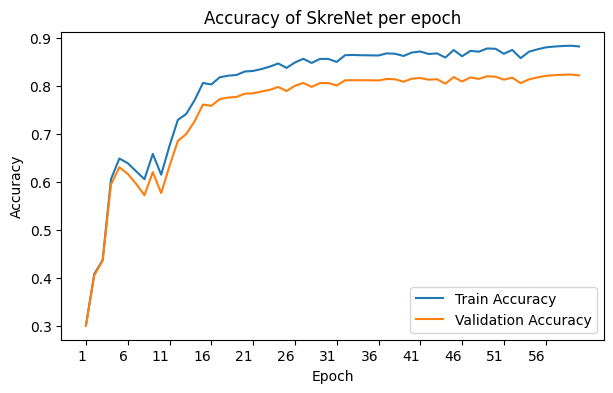

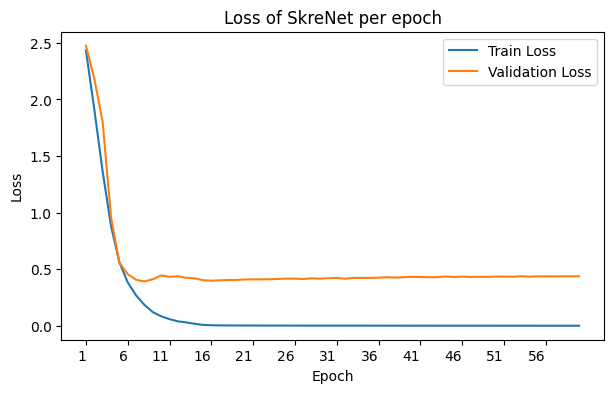

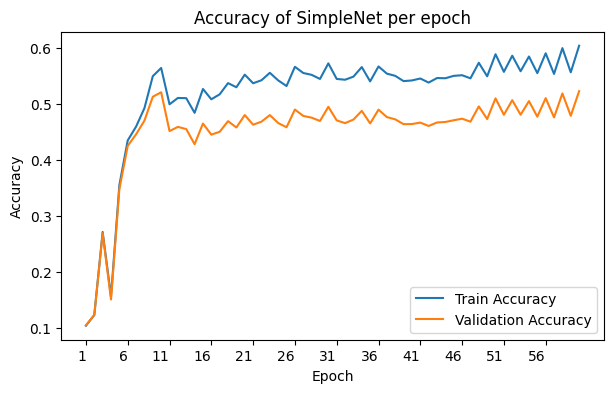

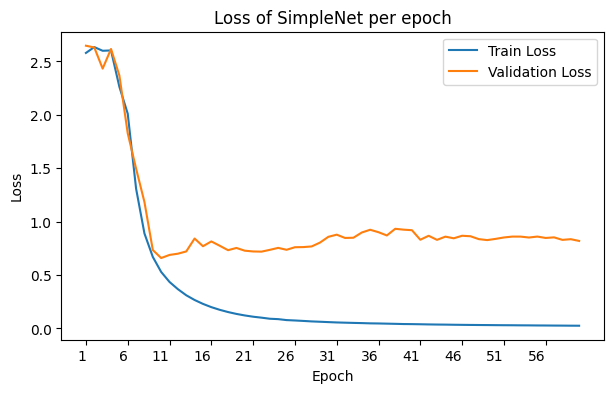

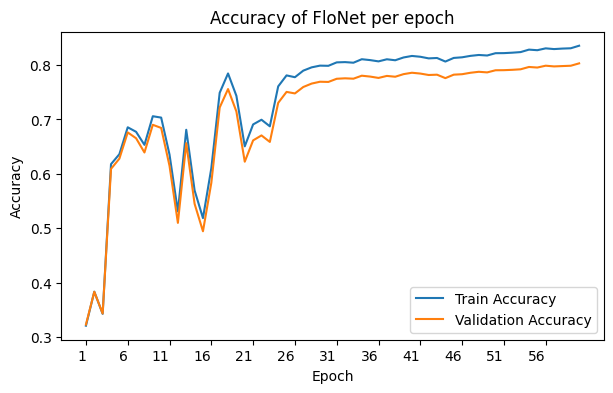

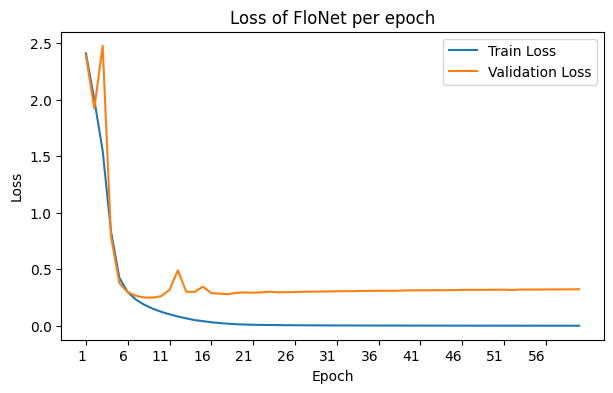

In [17]:
plot_scores(skre_net, skre_model_1_performance)
plot_scores(skre_net, skre_loss_1)

plot_scores(simple_net, simple_model_1_performance)
plot_scores(simple_net, simple_loss_1)

plot_scores(flo_net, flo_model_1_performance)
plot_scores(flo_net, flo_loss_1)

In [17]:
def compare_results(models, model_performances, test_loader, task, device=device):
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

    for i, (model, model_performance) in enumerate(zip(models, model_performances), start=1):
        val_acc = [x[1] for x in model_performance]
        ax.plot(range(len(val_acc)), val_acc, linestyle='-', label=f'Model {model.__class__.__name__} Validation Accuracy')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Validation Accuracy')
    ax.set_title('Validation Accuracy Comparison of Different Models per Epoch')
    ax.set_xticks(range(1, len(val_acc), 5))
    ax.legend()

    plt.tight_layout()
    plt.show()

    skre_performance, simple_performance, flo_performance = model_performances
    #finding the best epoch and the best validation accuracy for each model
    epoch_skre, best_skre = max(enumerate(skre_performance), key=lambda x: x[1])
    epoch_simple, best_simple = max(enumerate(simple_performance), key=lambda x: x[1])
    epoch_flo, best_flo = max(enumerate(flo_performance), key=lambda x: x[1])

    #finding the best model by finding the highest validation accuracy
    best_model_tup = max((models[0], best_skre, epoch_skre), (models[1], best_simple, epoch_simple), (models[2], best_flo, epoch_flo), key=lambda x: x[1])
    best_model = best_model_tup[0].to(device)
    best_model_score = best_model_tup[1][1]
    best_model_epoch = best_model_tup[2]

    comb_acc, detect_acc, box_acc = performance(best_model, test_loader, task=task)
    print()
    print()
    print(f'-------------Performance of the best model-----------------')
    print()
    print(f'Model: {best_model.__class__.__name__} at epoch {best_model_epoch}')
    print(f'Validation average accuracy: {best_model_score}')
    print()
    print(f'-------------ACCURACIES ON TEST DATA-----------------')
    print()
    print(f'Detection & class labelig:')
    print(f'{round(detect_acc*100, 4)}%')
    print()
    print(f'Box accuracy:')
    print(f'{round(box_acc*100, 4)}%')
    print()
    print(f'Average accuracy on test data:')
    print(f'{round(comb_acc*100, 4)}%')

    return best_model

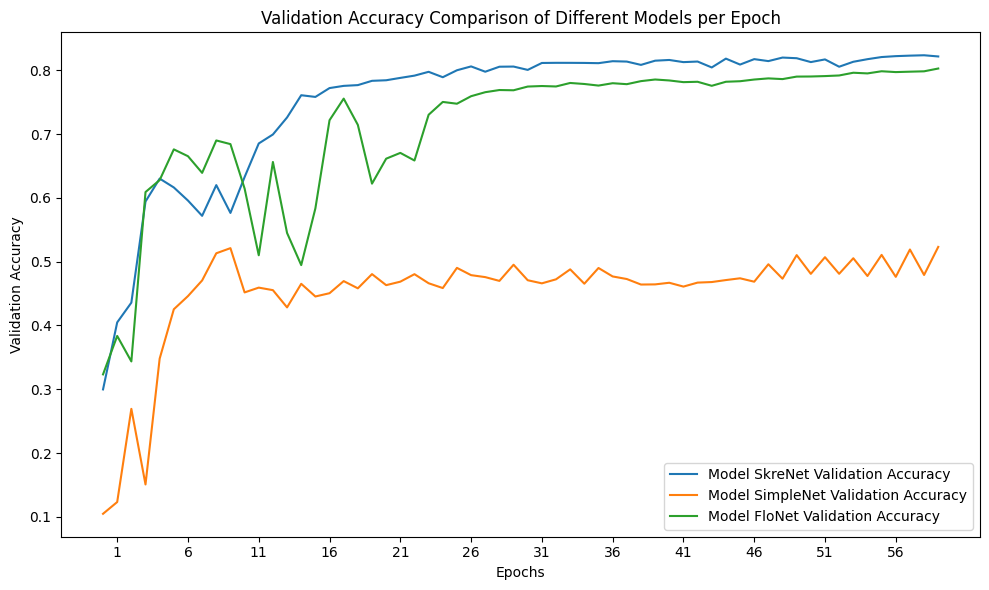



-------------Performance of the best model-----------------

Model: SkreNet at epoch 58
Validation average accuracy: 0.8237028121948242

-------------ACCURACIES ON TEST DATA-----------------

Detection & class labelig:
92.6364%

Box accuracy:
72.6757%

Average accuracy on test data:
82.656%


In [18]:
#plots the best model automaticly by comparing the validation accuracy of the models from the previous cell
models = [skre_net, simple_net, flo_net]  # Assuming you have three different models
model_performances_1 = [skre_model_1_performance, simple_model_1_performance, flo_model_1_performance]

test_loader = torch.utils.data.DataLoader(data_test, batch_size=32, shuffle=False)
best_model_1 = compare_results(models, model_performances_1, test_loader=test_loader, task='loc')



----------------Example predictions of the best model on test data-----------------------




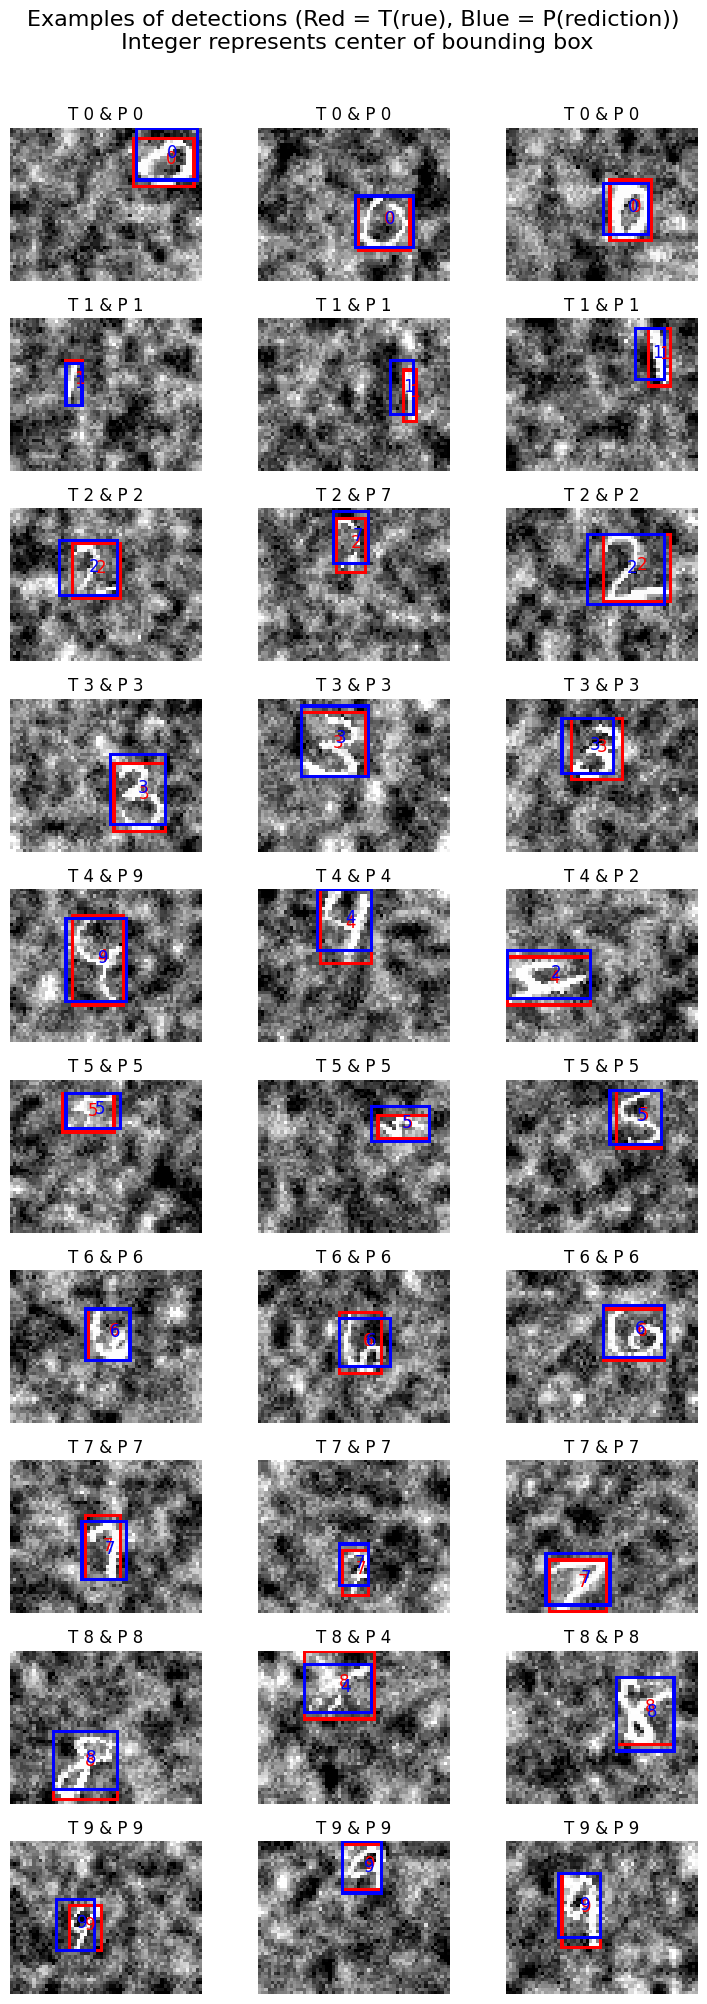

In [41]:
print()
print()
print('----------------Example predictions of the best model on test data-----------------------')
print()
print()
batch_size = 32
num_classes = 10
examples_per_class = 3
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False)
class_examples = {i: [] for i in range(num_classes)}

#this function is used to plot the examples of the best model
#we use the defined draw_bb function to plot the images
#we find 3 examples for each class and plot them in a 10x3 grid
#the red boxes are the true boxes and the blue boxes are the predicted boxes

best_model_1.eval()
with torch.no_grad():
    for inputs, labels in test_loader:

        imgs = inputs.to(device=device)
        labels = labels.to(device=device)

        outputs = skre_net(imgs)

        pred_box = outputs[:,1:5]
        _, pred_class = torch.max(outputs[:, 5:], dim=1)
        pred_detection = torch.sigmoid(outputs[:,0])

        true_class = labels[:, 5]
        true_box = labels[:,1:5]
        true_detection = labels[:,0]

        for img, t_box, p_box, t_class, p_class, true_det, pred_det  in zip(imgs, true_box,
                                                                            pred_box, true_class,
                                                                            pred_class, true_detection,
                                                                            pred_detection):

            if true_det == 1 and pred_det >= 0.5:
                if len(class_examples[t_class.item()]) < examples_per_class:
                    class_examples[t_class.item()].append((img, t_box, p_box, t_class, p_class))


fig, axis = plt.subplots(nrows=10, ncols=3, figsize=(8,20))
for i in range(num_classes):
    for example_idx, (img, t_box, p_box, t_class, p_class) in enumerate(class_examples[i]):
        ax = axis[i][example_idx]
        draw_bb(img=img, true_box=t_box, pred_box=p_box, true_class=t_class, pred_class=p_class, ax=ax, denorm=[mean_loc, std_loc])
        ax.axis('off')
        fig.suptitle('Examples of detections (Red = T(rue), Blue = P(rediction))\n Integer represents center of bounding box\n'
                     , fontsize=16, y=1)
        fig.tight_layout()

# Part 2 Object Detection

Loading and fixing ``list_y_true_XXX`` files


The files here are of length ``n``. This means that there will be ``n`` elements in each list of tensor. Each list of tensor can be accessed by looping over ``y_true_train[i]`` to see all the elememts listed.

``IDEA: Plot the distribution of the each class here?``

Here I suggest creating a tampor proof function that reshapes

``TODO: Needs to find out if each subtensor needs to be discarded in case there is a a digiti > 2 in it``

In [20]:
# For google colab

list_y_true_paths = ['/content/drive/MyDrive/inf265-p2/data/list_y_true_train.pt',
                      '/content/drive/MyDrive/inf265-p2/data/list_y_true_val.pt',
                     '/content/drive/MyDrive/inf265-p2/data/list_y_true_test.pt']

detection_paths = ['/content/drive/MyDrive/inf265-p2/data/detection_train.pt',
          '/content/drive/MyDrive/inf265-p2/data/detection_val.pt',
          '/content/drive/MyDrive/inf265-p2/data/detection_test.pt']

# For main computer

#list_y_true_paths = ['data/list_y_true_train.pt',
#                     'data/list_y_true_val.pt',
#                    'data/list_y_true_test.pt']

#detection_paths = ['data/detection_train.pt',
#                   'data/detection_val.pt',
#                   'data/detection_test.pt']

preprocessor_det, mean_det, std_det = norm_data(detection_paths[0])

list_y_true_train, list_y_true_val, list_y_true_test = load_custom_dataset(list_y_true_paths)
detection_train, detection_val, detection_test = load_custom_dataset(detection_paths, preprocessor=preprocessor_det)

datasets_to_combine = [[detection_train, list_y_true_train],
                        [detection_val, list_y_true_val],
                        [detection_test, list_y_true_test]]

In [21]:
def reverse_to_global_idx(cell_x, cell_y, local_x, local_y, local_w, local_h, Gh=2, Gw=3):
    # Function to reverse the local coordinates to global coordinates
    x = (cell_x + local_x) / Gw
    y = (cell_y + local_y) / Gh
    w = local_w / Gw
    h = local_h / Gh
    return x, y, w, h

def get_grid_detections(cells, true_cells=None, GH=2, GW=3):

    #this function is used to get the detections indiceses from the cells
    grid_shape = (GH, GW)
    #if you pass true_cells as an argument the function will return the true detections

    if true_cells:
        cells = torch.permute(cells, (0,3,1,2))
        detections = cells[:,0]
        detections_reshaped = detections.view(grid_shape)
        detections_indices = detections_reshaped.nonzero()
    #else it will return the indices of the predicitons
    else:
        pred_detections = torch.sigmoid(cells[:,0])
        threshold = 0.5
        pred_detections_reshaped = pred_detections.view(grid_shape)

        detections = pred_detections_reshaped > threshold
        detections_indices = detections.nonzero()
    return detections_indices

def extract_values_from_output(cells, detection_indices, true_cells=None):
    #this function is used to extract the values from the cells
    #if true_cells is passed as an argument it will return the true values
    #else it will return the predicted values
    #this is used to plot the boxes later on
    boxes = []
    if true_cells:
        cells = torch.permute(cells, (0,3,1,2))
    for i in range(detection_indices.shape[0]):

        #finds the x and y coordinates of the detections
        #finds the local x, y, w, h and the label with sigmoid
        y, x = detection_indices[i]
        cell_x, cell_y = detection_indices[i][1].item(), detection_indices[i][0].item()
        cells_list = cells[:,:, y.item(), x.item()].flatten().tolist()
        cells_tensor = cells[:,:, y.item(), x.item()].flatten()

        local_x, local_y, local_w, local_h = cells_list[1:5]
        global_x, global_y, global_w, global_h = reverse_to_global_idx(cell_x, cell_y, local_x, local_y, local_w, local_h)
        label = torch.sigmoid(cells_tensor[-1])
        if label >= 0.5:
            label = 1
        else:
            label = 0


        boxes.append([cells_tensor[0], global_x, global_y, global_w, global_h, label])

    return boxes


In [22]:
def save_combined_datasets(datasets_to_combine):
    #this super function combines the detections and the true labels
    #for datasets that are used to train the models in task 2
    def change_coordinates(x, y, w, h, Gh=2, Gw=3):

        #to compute the cell index
        cell_x = int(x * Gw)
        cell_y = int(y * Gh)

        #computes the local x and y coordinates
        local_x = (x * Gw) - cell_x
        local_y = (y * Gh) - cell_y

        #computes the local width and height
        local_w = (w * Gw)
        local_h = (h * Gh)

        #below we check if the cell index is equal to the grid size
        #the code below is used to ensure that the local x and y coordinates
        #are inside the grid space

        if cell_x == Gw:
            cell_x -= 1
            local_x = 1

        if cell_y == Gh:
            cell_y -= 1
            local_y = 1

        if local_x == 0:
            local_x = 1
            cell_x -= 1

        if local_y == 0:
            local_y = 1
            cell_y -= 1

        return cell_x, cell_y, local_x, local_y, local_w, local_h

    def combine_labels_and_images(det_labels, list_y_true_labels, Gh=2, Gw=3):
        det_labels = [img for img, _ in det_labels]
        all_images = []
        all_boxes = []
        for images, boxes in zip(det_labels, list_y_true_labels):

            for img in images:
                img.unsqueeze_(0)
                img_boxes = torch.zeros(Gh, Gw, 6)

                for box in boxes:
                    cell_x, cell_y, local_x, local_y, local_w, local_h = change_coordinates(box[1], box[2], box[3], box[4], Gh, Gw)
                    img_boxes[cell_y, cell_x] = torch.tensor([box[0], local_x, local_y, local_w, local_h, box[5]])

                all_images.append(img)
                all_boxes.append(img_boxes)

        stacked_images = torch.stack(all_images)
        stacked_boxes = torch.stack(all_boxes)

        dataset = torch.utils.data.TensorDataset(stacked_images, stacked_boxes)
        return dataset

    final_datasets = []
    for det_label, p3_label in datasets_to_combine:
        combined_dataset = combine_labels_and_images(det_label, p3_label)
        final_datasets.append(combined_dataset)
    return final_datasets

In [23]:
#loading the datasets for task 2

data_train_det, data_val_det, data_test_det = save_combined_datasets(datasets_to_combine)

In [24]:
class SkreNet_2(nn.Module):
    def __init__(self):
        super(SkreNet_2, self).__init__()

        # First layer
        self.cv1 = nn.Conv2d(1, 10, 3, stride=1, padding=1)
        self.act1 = nn.ReLU()

        # Second layer
        self.cv2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.act2 = nn.ReLU()

        # Third layer
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fourth layer
        self.cv3 = nn.Conv2d(20, 40, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(40)
        self.act3 = nn.ReLU()

        # Fifth layer
        self.cv4 = nn.Conv2d(40, 60, (3,5), stride=1, padding=1)
        self.act4 = nn.ReLU()

        # Sixth layer
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Seventh layer
        self.cv5 = nn.Conv2d(60, 80, 3, stride=1, padding=1)
        self.act5 = nn.ReLU()

        # Eigth layer
        self.cv6 = nn.Conv2d(80, 100, 3, stride=1, padding=1)
        self.act6 = nn.ReLU()

        # Ninth layer
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Tenth layer
        self.cv7 = nn.Conv2d(100, 120, (5,4), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(120)
        self.act7 = nn.ReLU()

        # Eleventh layer
        self.cv8 = nn.Conv2d(120, 100, 3, stride=1, padding=1)
        self.act8 = nn.ReLU()

        # Twealth layer
        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Thirteenth layer
        self.cv9 = nn.Conv2d(100, 50, 3, stride=1, padding=1)
        self.act9 = nn.ReLU()

        # Fourteenth
        self.cv10 = nn.Conv2d(50, 20, 3, stride=1, padding=1)
        self.act10 = nn.ReLU()

        # Output layer
        self.cv11 = nn.Conv2d(20, 6, 3, stride=1, padding=1)


    def forward(self, x):
        out = self.act1(self.cv1(x))       # The output of the 1. layer and activation functions is the input of the next
        out = self.act2(self.cv2(out))
        out = self.mp1(out)

        out = self.cv3(out)
        out = self.act3(self.bn1(out))
        out = self.act4(self.cv4(out))
        out = self.mp2(out)

        out = self.act5(self.cv5(out))
        out = self.act6(self.cv6(out))
        out = self.mp3(out)

        out = self.cv7(out)
        out = self.act7(self.bn2(out))
        out = self.act8(self.cv8(out))
        out = self.mp4(out)

        out = self.act9(self.cv9(out))
        out = self.act10(self.cv10(out))
        out = self.cv11(out)                # The last layer has dimentions (batch x 2 x 3 x 7)

        return out

In [25]:
class SimpleNet_2(nn.Module):
    def __init__(self):
        super(SimpleNet_2, self).__init__()

        # First layer
        self.cv1 = nn.Conv2d(1, 10, 3, stride=1, padding=1)
        self.act1 = nn.ReLU()

        # Second layer
        self.cv2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.act2 = nn.ReLU()

        # Third layer
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fourth layer
        self.cv3 = nn.Conv2d(20, 35, (3,5), stride=1, padding=1)
        self.act3 = nn.ReLU()

        # Fifth layer
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Sixth layer
        self.cv4 = nn.Conv2d(35, 40, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(40)
        self.act4 = nn.ReLU()


        # Seventh layer
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Eigth layer
        self.cv5 = nn.Conv2d(40, 20, (5,4), stride=1, padding=1)
        self.act5 = nn.ReLU()

        # Ninth layer
        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Output layer
        self.cv6 = nn.Conv2d(20, 6, 3, stride=1, padding=1)


    def forward(self, x):
        out = self.act1(self.cv1(x))       # The output of the 1. layer and activation functions is the input of the next
        out = self.act2(self.cv2(out))
        out = self.mp1(out)

        out = self.act3(self.cv3(out))
        out = self.mp2(out)

        out = self.cv4(out)
        out = self.act4(self.bn1(out))

        out = self.mp3(out)

        out = self.act5(self.cv5(out))
        out = self.mp4(out)

        out = self.cv6(out)                # The last layer has dimentions (batch x 2 x 3 x 7)

        return out

In [26]:
class FloNet_2(nn.Module):
    def __init__(self):
        super(FloNet_2, self).__init__()

        # First layer
        self.cv1 = nn.Conv2d(1, 10, 3, stride=1, padding=1)
        self.act1 = nn.ReLU()

        # Second layer
        self.cv2 = nn.Conv2d(10, 25, 3, stride=1, padding=1)
        self.act2 = nn.ReLU()

        # Second layer
        self.cv3 = nn.Conv2d(25, 50, 3, stride=1, padding=1)
        self.act3 = nn.ReLU()

        # Third layer
        self.cv4 = nn.Conv2d(50, 75, 3, stride=1, padding=1)
        self.act4 = nn.ReLU()

        # Fourth layer
        self.cv5 = nn.Conv2d(75, 100, 3, stride=1, padding=1)
        self.act5 = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(100)

        # Fifth layer
        self.cv6 = nn.Conv2d(100, 75, 4, stride=1, padding=0)
        self.act6 = nn.ReLU()

        # Sixth layer
        self.cv7 = nn.Conv2d(75, 50, 4, stride=1, padding=0)
        self.act7 = nn.ReLU()

        # Seventh layer
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # eighth layer
        self.cv8 = nn.Conv2d(50, 50, 4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(50)
        self.act8 = nn.ReLU()

        # Ninth layer
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 10th layer
        self.cv9 = nn.Conv2d(50, 25, (3,4), stride=1, padding=0)
        self.act9 = nn.ReLU()

        # 11th layer
        self.cv10 = nn.Conv2d(25, 15, (4,4), stride=1, padding=1)
        self.act10 = nn.ReLU()

        # 12th
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Output layer
        self.cv11 = nn.Conv2d(15, 10, (4,4), stride=1, padding=1)



    def forward(self, x):
        out = self.act1(self.cv1(x))       # The output of the 1. layer and activation functions is the input of the next
        out = self.act2(self.cv2(out))
        out = self.act3(self.cv3(out))
        out = self.act4(self.cv4(out))
        out = self.cv5(out)
        out = self.act5(self.bn1(out))

        out = self.act6(self.cv6(out))
        out = self.act7(self.cv7(out))
        out = self.mp1(out)

        out = self.cv8(out)
        out = self.act8(self.bn2(out))
        out = self.mp2(out)

        out = self.act9(self.cv9(out))
        out = self.act10(self.cv10(out))
        out = self.mp3(out)

        out = self.cv11(out)                # The last layer has dimentions (batch x 2 x 3 x 7)

        return out

In [39]:
task='det'

batch_size = 64
train_loader = torch.utils.data.DataLoader(data_train_det, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(data_val_det, batch_size=batch_size, shuffle=False)

n_epoch = 60
lr = 0.05
decay = 0

skre_net_2 = SkreNet_2()
simple_net_2 = SimpleNet_2()
flo_net_2 = FloNet_2()

skre_net_2_lastEpoch, skre_model_2_performance, skre_loss_2 = start_training(train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            n_epoch=n_epoch, lr=lr,
                                                            decay=decay, model=skre_net_2, task='det')

simple_net_2_lastEpoch, simple_model_2_performance, simple_loss_2 = start_training(train_loader=train_loader,
                                                                    val_loader=val_loader,
                                                                    n_epoch=n_epoch, lr=lr,
                                                                    decay=decay, model=simple_net_2, task='det')

flo_net_2_lastEpoch, flo_model_2_performance, flo_loss_2 = start_training(train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            n_epoch=n_epoch, lr=lr,
                                                            decay=decay, model=flo_net_2, task='det')




16:50:31.517620  |  Epoch 1  |  Training loss 0.631 | Validation loss 0.222

 --- Accuracies ---
Training:  0.6005713939666748
Validation: 0.5984998345375061

16:51:28.539632  |  Epoch 10  |  Training loss 0.027 | Validation loss 0.070

 --- Accuracies ---
Training:  0.7376246452331543
Validation: 0.736790657043457

16:52:32.985686  |  Epoch 20  |  Training loss 0.007 | Validation loss 0.057

 --- Accuracies ---
Training:  0.7981675863265991
Validation: 0.7925283908843994

16:53:36.600127  |  Epoch 30  |  Training loss 0.004 | Validation loss 0.057

 --- Accuracies ---
Training:  0.8145245313644409
Validation: 0.8071061968803406

16:54:40.919691  |  Epoch 40  |  Training loss 0.004 | Validation loss 0.058

 --- Accuracies ---
Training:  0.8252257108688354
Validation: 0.8153553605079651

16:55:43.687384  |  Epoch 50  |  Training loss 0.003 | Validation loss 0.058

 --- Accuracies ---
Training:  0.8367663621902466
Validation: 0.8244270086288452

16:56:47.012676  |  Epoch 60  |  Training 

In [72]:
#same as before we save the models and their performance in a dictionary

model_dict_2 = {
    'skre' : {'mp': skre_model_2_performance, 'loss': skre_loss_2},
    'simple' : {'mp' : simple_model_2_performance, 'loss': simple_loss_2},
    'flo' : {'mp' : flo_model_2_performance, 'loss' : flo_loss_2},
}
file_path = "/content/drive/MyDrive/inf265-p2/new_models/model_dict_2"


with open(file_path, 'wb') as f:
    pickle.dump(model_dict_2, f)

In [27]:
#same as before we load the models and the model dictionary

file_path = "/content/drive/MyDrive/inf265-p2/new_models/model_dict_2"

with open(file_path, 'rb') as f:
    model_dict_2 = pickle.load(f)


skre_net_2 = SkreNet_2()
simple_net_2 = SimpleNet_2()
flo_net_2 = FloNet_2()

skre_state_dict = torch.load('/content/drive/MyDrive/inf265-p2/new_models/SkreNet_2.pt', map_location=device)
skre_net_2.load_state_dict(skre_state_dict)

simple_state_dict = torch.load('/content/drive/MyDrive/inf265-p2/new_models/SimpleNet_2.pt', map_location=device)
simple_net_2.load_state_dict(simple_state_dict)

flo_state_dict = torch.load('/content/drive/MyDrive/inf265-p2/new_models/FloNet_2.pt', map_location=device)
flo_net_2.load_state_dict(flo_state_dict)

<All keys matched successfully>

In [28]:

#same as before we load the model dictionary
skre_model_2_performance = model_dict_2['skre']['mp']
simple_model_2_performance = model_dict_2['simple']['mp']
flo_model_2_performance = model_dict_2['flo']['mp']

skre_loss_2 = model_dict_2['skre']['loss']
simple_loss_2 = model_dict_2['simple']['loss']
flo_loss_2 = model_dict_2['flo']['loss']

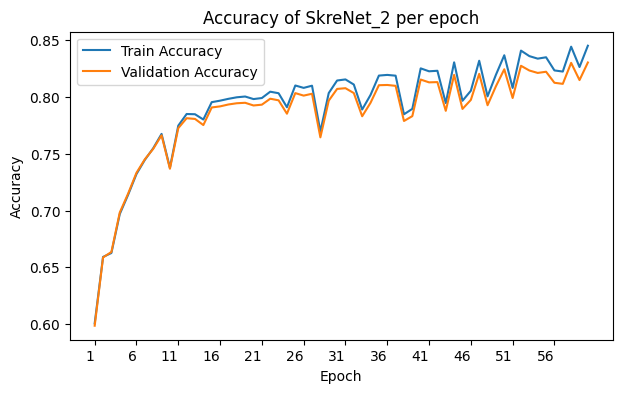

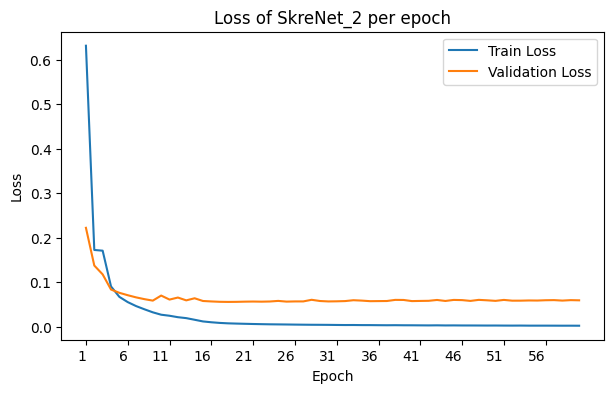

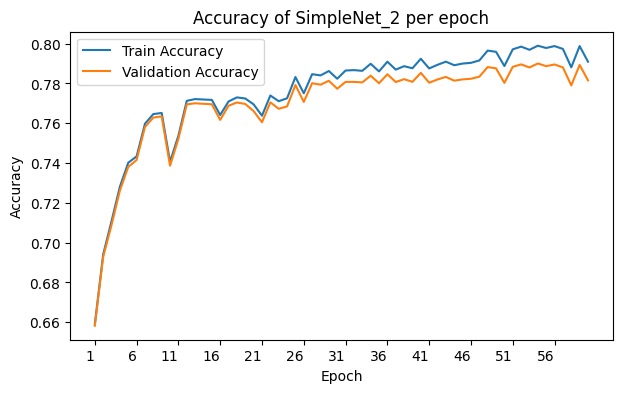

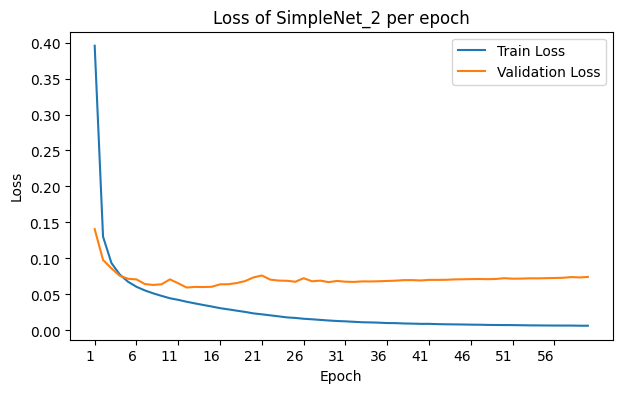

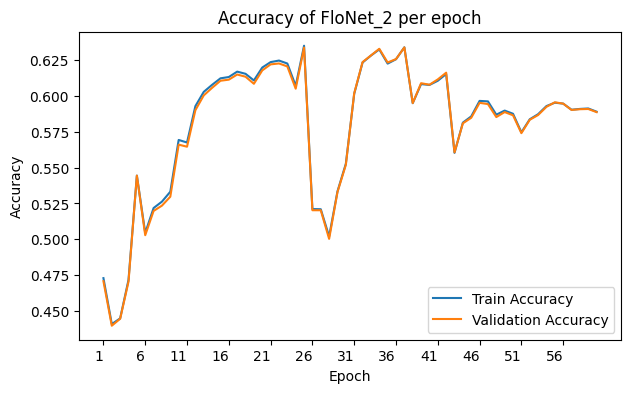

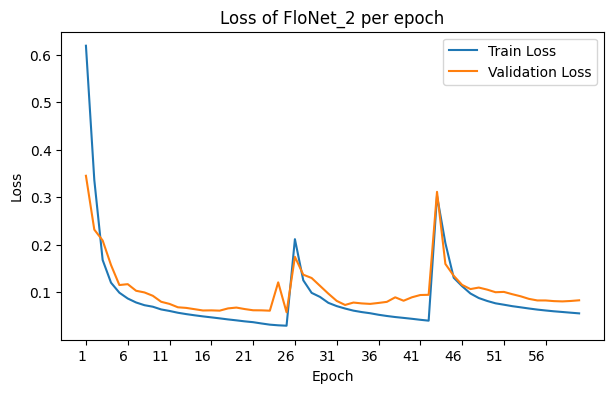

In [48]:
#plotting the scores of the models

plot_scores(skre_net_2, skre_model_2_performance)
plot_scores(skre_net_2, skre_loss_2)

plot_scores(simple_net_2, simple_model_2_performance)
plot_scores(simple_net_2, simple_loss_2)

plot_scores(flo_net_2, flo_model_2_performance)
plot_scores(flo_net_2, flo_loss_2)

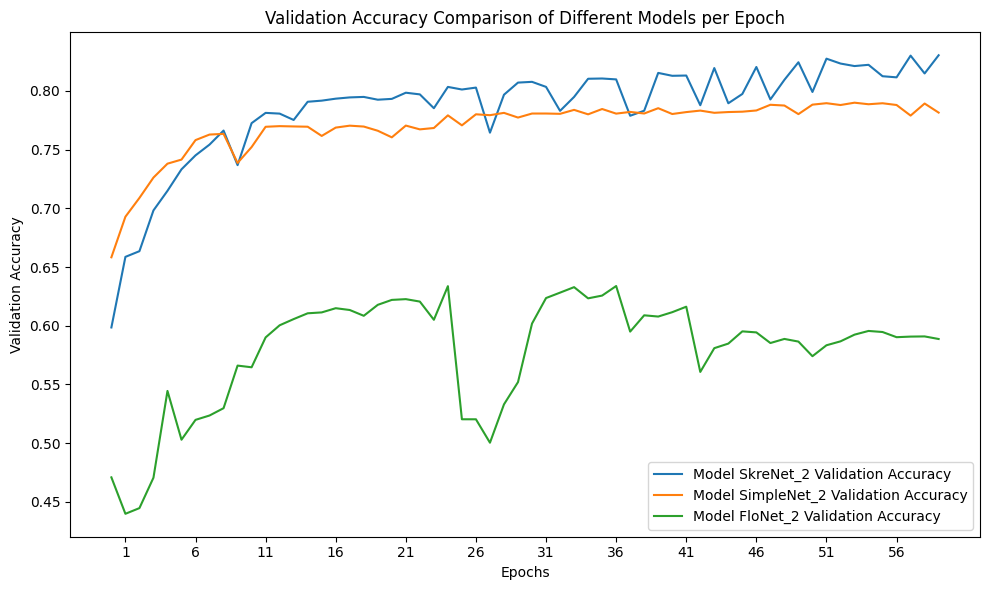



-------------Performance of the best model-----------------

Model: SkreNet_2 at epoch 59
Validation average accuracy: 0.8303920030593872

-------------ACCURACIES ON TEST DATA-----------------

Detection & class labelig:
87.6732%

Box accuracy:
78.0962%

Average accuracy on test data:
82.8847%


In [29]:
models = [skre_net_2, simple_net_2, flo_net_2]  # Assuming you have three different models
model_performances_2 = [skre_model_2_performance, simple_model_2_performance, flo_model_2_performance]

test_loader = torch.utils.data.DataLoader(data_test_det, batch_size=32, shuffle=False)
best_model_2 = compare_results(models, model_performances_2, test_loader=test_loader, task='det')

----------------Example predictions of the best model on test data-----------------------




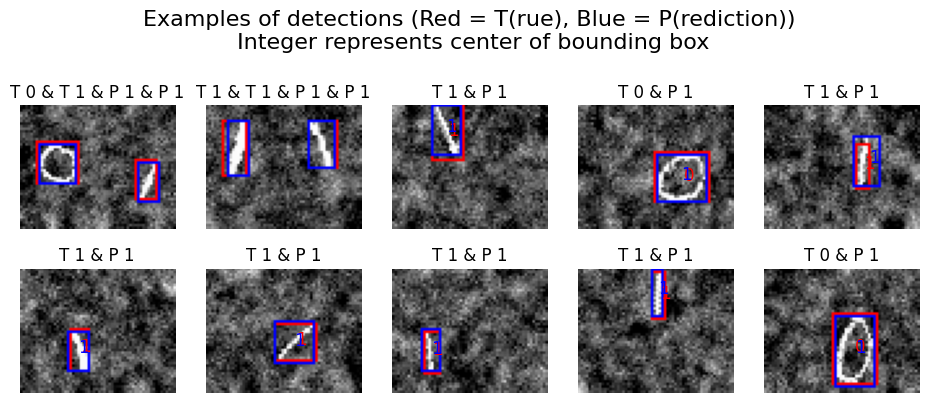

In [47]:
print('----------------Example predictions of the best model on test data-----------------------')
print()
print()
skre_net_2.eval()
batch_size = 1
num_plots = 10
val_loader = torch.utils.data.DataLoader(data_val_det, batch_size=batch_size, shuffle=False)


nrows = 2
ncols = 5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axs = axs.flatten()

i = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        if i >= num_plots:
            break
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)

        outputs = skre_net_2(imgs)
        # Get the detections indices
        pred_det_idx = get_grid_detections(outputs)
        pred_cells = extract_values_from_output(outputs, pred_det_idx)

        # Get the true detections indices
        true_det_idx = get_grid_detections(labels, true_cells=True)
        true_cells = extract_values_from_output(labels, pred_det_idx, true_cells=True)

        p_class, t_class, p_box, t_box = [], [], [], []

        #here we extract the values from the cells that correspond to the true and predicted detections
        for cell in zip(true_cells, pred_cells):
            p_box.append(torch.tensor(cell[0][1:5]))
            p_class.append(cell[0][5])
            t_box.append(torch.tensor(cell[1][1:5]))
            t_class.append(cell[1][5])

        p_class, t_class = torch.tensor(p_class), torch.tensor(t_class)
        #we plot the images with the true and predicted boxes
        if i < len(axs):
            ax = axs[i]
            draw_bb(img=imgs[0], true_box=t_box, pred_box=p_box, true_class=t_class, pred_class=p_class, ax=ax, denorm=[mean_det, std_det])
            ax.axis('off')

        i += 1

plt.subplots_adjust(left=0.2, right=0.8, top=.94, bottom=0.74)
fig.suptitle('Examples of detections (Red = T(rue), Blue = P(rediction))\n Integer represents center of bounding box\n'
                     , fontsize=16, y=1)
plt.show()
